In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
from src.functions import *
from src.nn.nn_actions import NeuralNetworkActions
from omegaconf import OmegaConf
from src.nn.nn_dataset import DataSampler


In [2]:
def plotting_solution_gridspec_custom(sol, modelling, model, num_of_points):
    fig, axs = plt.subplots(4, 1, figsize=(8, 10))
    """ when the dataset is too big apply this
    for i in range(len(sol)-10000):
        solution = sol[10000+i] 
    """
    for i in range(len(sol)):
        solution = sol[i] 
        axs[0].plot(solution[0][:num_of_points], (solution[1][:num_of_points]), label='δ (pu)')
        axs[1].plot(solution[0][:num_of_points], solution[2][:num_of_points], label='ω (rad/s)')
        axs[2].plot(solution[0][:num_of_points], solution[3][:num_of_points], label='E_d_dash (pu)')
        axs[3].plot(solution[0][:num_of_points], solution[4][:num_of_points], label='E_q_dash (pu)')
    
    axs[0].set_title(modelling)
    axs[0].set_ylabel('δ')
    axs[0].grid(True)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('ω (rad/s)')
    axs[1].grid(True)
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('E_d_dash (pu)')
    axs[2].grid(True)
    axs[3].set_xlabel('Time (s)')
    axs[3].set_ylabel('E_q_dash (pu)')
    axs[3].grid(True)
    plt.show()
    return None

Plot the ode solutions, note that theta is transformed with tanh(theta)

Total trajectories 500
Total samples of all the trajectories 2500000


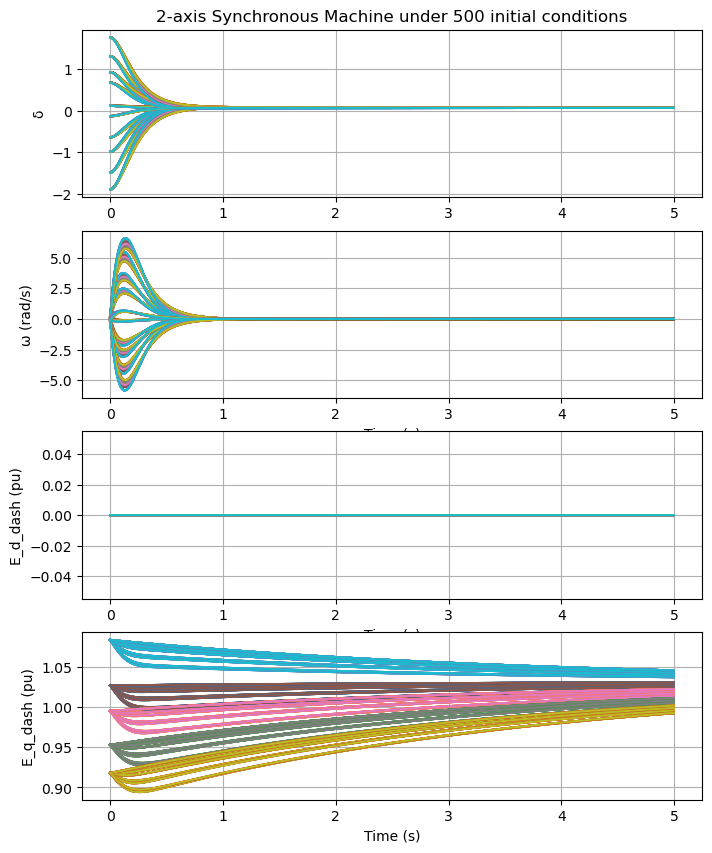

In [3]:
modelling  = 'SM' #  'SM_IB' or 'SM' or 'SM_AVR' or 'SM_AVR_GOV'
number_of_dataset = 12
name = 'data/'+ modelling + '/dataset_v' + str(number_of_dataset) + '.pkl'
with open(name, 'rb') as f:
    sol = pickle.load(f)

modelling = "2-axis Synchronous Machine under 500 initial conditions"
num_of_points = 1250
number_of_dataset = 1
print("Total trajectories", len(sol))
print("Total samples of all the trajectories", len(sol[0][0])*len(sol))
plotting_solution_gridspec_custom(sol, modelling, number_of_dataset, num_of_points)

All the combinations

Plot derivatives of the solution. The derivatives are accessed through the PINN framework, which has embedded the respective ODE framework

In [4]:
# Define training parameters

cfg = OmegaConf.load("src/conf/setup_dataset_nn.yaml")
"""data loader is embedded in the neural network class"""
"""
data_loader = DataSampler(cfg)
data = data_loader.load_data()
x_data_list = data_loader.x
y_data_list = data_loader.y
"""
#run = wandb.init(project=cfg.wandb.project)
#log_data_metrics_to_wandb(run, cfg)
#log_pinn_metrics_to_wandb(run, cfg)
network = NeuralNetworkActions(cfg)

Loading data from:  data\SM/dataset_v13.pkl


c:\Users\Giannis\Desktop\Thesis\Pinn-Thesis\src\nn\nn_dataset.py:185: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  training_sample = torch.tensor(training_sample, dtype=torch.float32) # convert the trajectory to tensor


Number of training samples:  400000 Number of validation samples:  50000 Number of testing samples:  50000
Number of different initial conditions for collocation points:  500
[[-2, 2], [-0.2, 0.2], [0], [0.9, 1.1]] Set of values for init conditions
[10, 10, 1, 5] Iterations per value
src/conf/params\system1.yaml


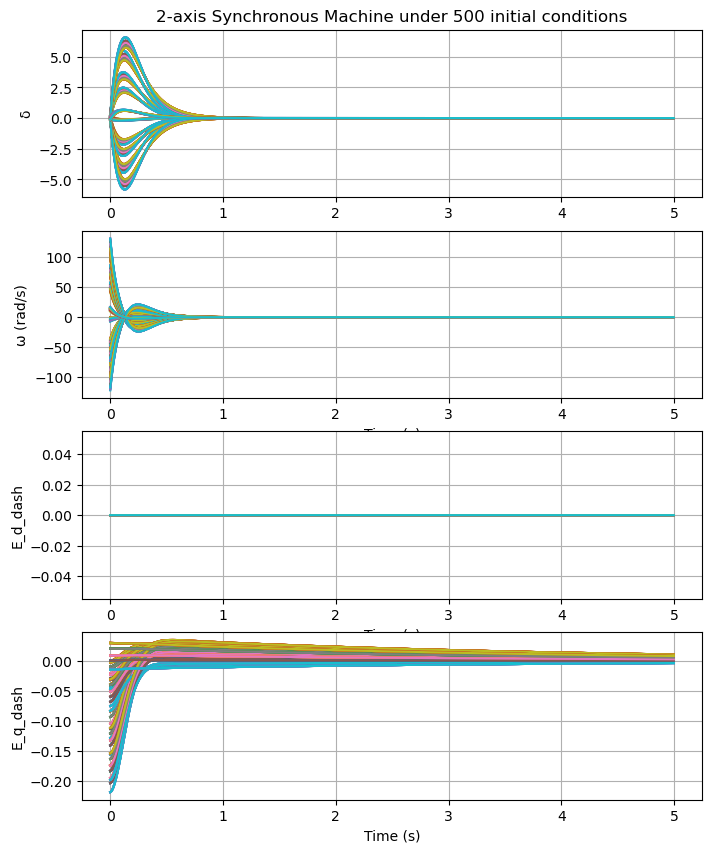

In [5]:

num_of_points=1250
plotting_solution_gridspec_dt(network,sol, modelling, number_of_dataset, num_of_points)

Inference trained model

In [63]:
from src.nn.nn_inference import *

network.data_loader.x_test.shape

cfg = OmegaConf.load("src/conf/setup_dataset_nn.yaml")
cfg.time = 1
network = NeuralNetworkActions(cfg)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_train_list = network.data_loader.x_test.to(device)
y_train_list = network.data_loader.y_test.to(device)
y_train_list = y_train_list.detach().cpu().numpy()

nameNN = "data_dt_pinn\SMDynamicNN_1_500_13794_38462_10000_1_0.0001_1e-05_Sam.pth"
y_predNN = predict(nameNN, "DynamicNN", x_train_list, cfg)

#find loss2 for each model
#calculate mse loss
lossNN = np.mean((y_train_list-y_predNN)**2)

print("lossNN  ", lossNN)


Loading data from:  data\SM/dataset_v2.pkl
Number of training samples:  400000 Number of validation samples:  50000 Number of testing samples:  50000
Number of different initial conditions for collocation points:  500
[[-2, 2], [-0.2, 0.2], [0], [0, 2]] Set of values for init conditions
[10, 10, 1, 5] Iterations per value
src/conf/params\system1.yaml
lossdata 1.0841229e-05
lossNN   7.581334e-06
lossA    2.0807536e-05


In [ ]:

fig, axs = plt.subplots(2, 1, figsize=(8, 6))
flag = ["Baseline", "Pinn", "PinnA", "Data"]

sample_per_traj = 1000
starting_traj = 15
total_traj = 100
time = x_train_list[starting_traj*sample_per_traj:(starting_traj+total_traj)*sample_per_traj, 0]
baseline = y_train_list[starting_traj*sample_per_traj:(starting_traj+total_traj)*sample_per_traj]
mse_nn = torch.nn.MSELoss()
loss_nn = [mse_nn(torch.tensor(baseline[:, i]), torch.tensor(y_predNN[starting_traj*sample_per_traj:(starting_traj+total_traj)*sample_per_traj, i])) for i in range(4)]
#keep only 6 decimal points
loss_nn = [round(loss_nn[i].item(), 6) for i in range(4)]

#plt.suptitle('Comparison of Baseline, Pinn and PinnA')
y_label = ['Theta', 'Omega', 'E_d_dash', 'E_q_dash']
for j in range(baseline.shape[1]):
    i = j%2
    axs[i].plot(time, baseline[:,j], label=flag[0],alpha=0.7)
    axs[i].plot(time, y_predNN[starting_traj*sample_per_traj:(starting_traj+total_traj)*sample_per_traj, j], label=flag[1],alpha=0.7)    
    axs[i].set_ylabel(y_label[j])
    axs[i].set_xlabel('Time (s)')
    axs[i].legend()
    axs[i].grid(True)
    # add more space between subplots
    plt.subplots_adjust(hspace=0.5)
    if j == 1:
        plt.show()
        fig, axs = plt.subplots(2, 1, figsize=(8, 6))

In [ ]:

fig, axs = plt.subplots(4, 1, figsize=(8, 12))
flag = ["FCNN"]

sample_per_traj = 1000
starting_traj = 0
total_traj = 1
time = x_train_list[starting_traj*sample_per_traj:(starting_traj+total_traj)*sample_per_traj, 0]
baseline = y_train_list[starting_traj*sample_per_traj:(starting_traj+total_traj)*sample_per_traj]
mse_nn = torch.nn.MSELoss()
loss_nn = [mse_nn(torch.tensor(baseline[:, i]), torch.tensor(y_predNN[starting_traj*sample_per_traj:(starting_traj+total_traj)*sample_per_traj, i])) for i in range(4)]
loss_nn = [round(loss_nn[i].item(), 6) for i in range(4)]
loss_a = [round(loss_a[i].item(), 6) for i in range(4)]

y_label = ['Theta', 'Omega', 'E_d_dash', 'E_q_dash']
for i in range(baseline.shape[1]):
    axs[i].plot(time, baseline[:,i], label=flag[0],alpha=0.7)
    axs[i].plot(time, y_predNN[starting_traj*sample_per_traj:(starting_traj+total_traj)*sample_per_traj, i], label=flag[1],alpha=0.7)
    axs[i].set_ylabel(y_label[i])
    axs[i].set_xlabel('Time (s)')
    
    title = 'Loss of Pinn', loss_nn[i], 'and Loss of PinnA', loss_a[i]
    axs[i].set_title(title, fontsize=10)
    axs[i].legend()
    axs[i].grid(True)
    plt.subplots_adjust(hspace=0.5)

In [ ]:

plt.figure(figsize=(15, 6))
starting_traj = 1000
ending=1000
for i in range(y_train_list.shape[1]):
    plt.subplot(1, 2, i % 2 + 1)  # Create subplots, alternating between two columns
    time = x_train_list[starting_traj:starting_traj+ending, 0]
    baseline = y_train_list[starting_traj:starting_traj+ending, i]
    plt.plot(time, baseline,  label='Original data')
    plt.plot(time, y_predNN[starting_traj:starting_traj+ending, i],  label='Fitted line NN')
    #plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, label='Physics loss training locations')
    print(torch.mean(torch.abs(torch.tensor(y_train_list[:, i]) - torch.tensor(y_predNN[:, i]))), "nn")
    #plt.plot(x_train_list[:,0], y_predAA[:, i],  label='Fitted line AA')
    plt.legend()
    if i % 2 != 0:
        plt.show()  # Show the plot after every two iterations